# Load the data

plan:
    1. aggregate by sum() everything possible
    2. get proportions of health and indicators of dead players
    3. create features for coordinates
    4. generate something for level
    5. dummy variables for game_mode
    6. ....scaling will be done in the training part (CV)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']= 100
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
# train_damage = pd.read_csv('train_features_damage_agg.csv', index_col='match_id_hash')
# test_damage = pd.read_csv('train_features_damage_agg.csv', index_col='match_id_hash')

In [3]:
# damage_col = train_damage.columns.values
# damage_col

In [4]:
# load the data and combine with test data to perform some of the trasformations (without standartization) on all data at the same time
train_df = pd.read_csv('train_features_plus.csv', index_col='match_id_hash')
# train_df = train_df.merge(train_damage, how='inner', left_index=True, right_index=True)
test_df = pd.read_csv('test_features_plus.csv', index_col='match_id_hash')
# test_df = test_df.merge(test_damage, how='inner', left_index=True, right_index=True)

In [5]:
idx_split = train_df.shape[0]
full_df = pd.concat([train_df, test_df])
new_features = pd.DataFrame(index=full_df.index)
full_df.head(2)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,d5_ability_level,d5_max_hero_hit,d5_purchase_count,d5_count_ability_use,d5_damage_dealt,d5_damage_received
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0,0,0,0,0,164,6,4,2332,681
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0,0,4,164,11,7,2308,2154


# Building feautures on hero_ids

In [6]:
target = pd.read_csv(r'C:\Users\Tatiana\Documents\Programming\MLcourse competition\target_plus.csv', index_col = 'match_id_hash')['radiant_win']

full_train = train_df.merge(target, how='outer', left_index=True, right_index=True)
full_train.shape

(39675, 306)

In [7]:
hero_id_list = ['r{}_hero_id'.format(i) for i in range(1,6)] + ['d{}_hero_id'.format(i) for i in range(1,6)]
hero_ids = full_train[hero_id_list+['radiant_win']]
hero_ids_rad_win = hero_ids[hero_ids['radiant_win'] == True]
hero_ids_rad_lose = hero_ids[hero_ids['radiant_win'] == False]
# winning
winning_hero_ids1 = hero_ids_rad_win[['r{}_hero_id'.format(i) for i in range(1,6)]]
winning_hero_ids2 = hero_ids_rad_lose[['d{}_hero_id'.format(i) for i in range(1,6)]]
# losing
losing_hero_ids1 = hero_ids_rad_win[['d{}_hero_id'.format(i) for i in range(1,6)]]
losing_hero_ids2 = hero_ids_rad_lose[['r{}_hero_id'.format(i) for i in range(1,6)]]

In [8]:
# renaming columns
winning_hero_ids1.rename(columns = {'r1_hero_id':'1_id', 'r2_hero_id':'2_id', 
                              'r3_hero_id':'3_id','r4_hero_id':'4_id',
                                    'r5_hero_id':'5_id'}, inplace = True)
winning_hero_ids2.rename(columns = {'d1_hero_id':'1_id', 'd2_hero_id':'2_id', 
                              'd3_hero_id':'3_id','d4_hero_id':'4_id',
                                    'd5_hero_id':'5_id'}, inplace = True)

losing_hero_ids1.rename(columns = {'d1_hero_id':'1_id', 'd2_hero_id':'2_id', 
                              'd3_hero_id':'3_id','d4_hero_id':'4_id',
                                    'd5_hero_id':'5_id'}, inplace = True)
losing_hero_ids2.rename(columns = {'r1_hero_id':'1_id', 'r2_hero_id':'2_id', 
                              'r3_hero_id':'3_id','r4_hero_id':'4_id',
                                    'r5_hero_id':'5_id'}, inplace = True)

In [9]:
winning_hero_ids = pd.concat([winning_hero_ids1, winning_hero_ids2], axis=0)
winning_hero_ids.shape

(39675, 5)

In [10]:
losing_hero_ids = pd.concat([losing_hero_ids1, losing_hero_ids2], axis=0)
losing_hero_ids.shape

(39675, 5)

In [11]:
winning_hero_counts = winning_hero_ids['1_id'].value_counts().sort_index() + winning_hero_ids['2_id'].value_counts().sort_index() + winning_hero_ids['3_id'].value_counts().sort_index() + winning_hero_ids['4_id'].value_counts().sort_index() + winning_hero_ids['5_id'].value_counts().sort_index()
winning_hero_counts = winning_hero_counts.sort_values()
winning_hero_dict = winning_hero_counts.to_dict()

In [12]:
losing_hero_counts = losing_hero_ids['1_id'].value_counts().sort_index() + losing_hero_ids['2_id'].value_counts().sort_index() + losing_hero_ids['3_id'].value_counts().sort_index() + losing_hero_ids['4_id'].value_counts().sort_index() + losing_hero_ids['5_id'].value_counts().sort_index()
losing_hero_counts = losing_hero_counts.sort_values()
losing_hero_dict = losing_hero_counts.to_dict()

In [13]:
hero_counts_win_minus_lose = winning_hero_counts.sort_index() - losing_hero_counts.sort_index()
diff_hero_dict = hero_counts_win_minus_lose.to_dict()


In [14]:
from collections import Counter
total_games_dict = Counter(winning_hero_dict) + Counter(losing_hero_dict)
hero_id_normalize_dict = {k: (diff_hero_dict[k] / total_games_dict[k]) for k in diff_hero_dict}

In [15]:
ls_feature_cols = list(train_df.columns.values)

In [16]:
#hero id columns names
ls_r_hero_id = ['r{}_hero_id'.format(i) for i in range(1,6)]
ls_d_hero_id = ['d{}_hero_id'.format(i) for i in range(1,6)]
ls_hero_id = ls_r_hero_id + ls_d_hero_id

In [17]:
#run this cell only once! or else NaNs
for col in ls_hero_id:
    if col not in ls_feature_cols:
        ls_feature_cols.append(col+'_bool')
    ls_feature_cols.append(col+'success')
    full_df[col+'success'] = full_df[col].map(diff_hero_dict)
#     train_X[col+'success'] = train_X[col].map(diff_hero_dict)
#     test_X[col+'success'] = test_X[col].map(diff_hero_dict)

In [18]:
#run only once!
for col in ls_hero_id:
    if col not in ls_feature_cols:
        ls_feature_cols.append(col+'_bool')
    ls_feature_cols.append(col+'norm')
    full_df[col+'norm'] = full_df[col].map(hero_id_normalize_dict)
#     train_X[col+'norm'] = train_X[col].map(hero_id_normalize_dict)
#     test_X[col+'norm'] = test_X[col].map(hero_id_normalize_dict)

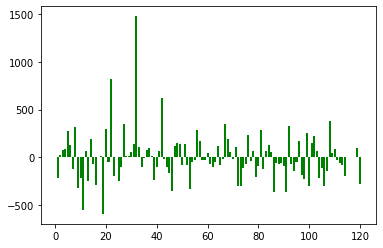

In [19]:
plt.bar(list(diff_hero_dict.keys()), diff_hero_dict.values(), color='g')
plt.show()

In [20]:
ls_top_heros = [k for k,v in hero_id_normalize_dict.items() if v > 0.1] + [k for k,v in diff_hero_dict.items() if v > 500]
ls_bottom_heros = [k for k,v in hero_id_normalize_dict.items() if v < -0.09] + [k for k,v in diff_hero_dict.items() if v < -500]

In [21]:
# for col in ls_hero_id:
#     if col not in ls_feature_cols:
#         ls_feature_cols.append(col+'_bool')
#     full_df[col+'_bool'] = np.where(full_df[col].astype(int).isin(ls_top_heros),2,np.where(full_df[col].isin(ls_bottom_heros),0,1))
# #     train_X[col+'_bool'] = np.where(train_X[col].astype(int).isin(ls_top_heros),2,np.where(train_X[col].isin(ls_bottom_heros),0,1))
#     test_X[col+'_bool'] = np.where(test_X[col].astype(int).isin(ls_top_heros),2,np.where(test_X[col].isin(ls_bottom_heros),0,1))

In [22]:
# for col in hero_id_list:
#     new_features[col] = full_df[col].map(diff_hero_dict)
#     train_df[col] = train_df[col].map(diff_hero_dict)
#     test_df[col] = test_df[col].map(diff_hero_dict)

In [23]:
ls_feature_cols.append('r_hero_idnorm')
full_df['r_hero_idnorm'] = full_df[['r{}_hero_idnorm'.format(i) for i in range(1,6)]].sum(axis=1)
# train_X['r_hero_idnorm'] = train_X[['r{}_hero_idnorm'.format(i) for i in range(1,6)]].sum(axis=1)
# test_X['r_hero_idnorm'] = test_X[['r{}_hero_idnorm'.format(i) for i in range(1,6)]].sum(axis=1)

In [24]:
ls_feature_cols.append('d_hero_idnorm')
full_df['d_hero_idnorm'] = full_df[['d{}_hero_idnorm'.format(i) for i in range(1,6)]].sum(axis=1)
# train_X['d_hero_idnorm'] = train_X[['d{}_hero_idnorm'.format(i) for i in range(1,6)]].sum(axis=1)
# test_X['d_hero_idnorm'] = test_X[['d{}_hero_idnorm'.format(i) for i in range(1,6)]].sum(axis=1)

In [25]:
full_df.columns[-100:]

Index(['d3_x', 'd3_y', 'd3_stuns', 'd3_creeps_stacked', 'd3_camps_stacked',
       'd3_rune_pickups', 'd3_firstblood_claimed',
       'd3_teamfight_participation', 'd3_towers_killed', 'd3_roshans_killed',
       'd3_obs_placed', 'd3_sen_placed', 'd3_ability_level', 'd3_max_hero_hit',
       'd3_purchase_count', 'd3_count_ability_use', 'd3_damage_dealt',
       'd3_damage_received', 'd4_hero_id', 'd4_kills', 'd4_deaths',
       'd4_assists', 'd4_denies', 'd4_gold', 'd4_lh', 'd4_xp', 'd4_health',
       'd4_max_health', 'd4_max_mana', 'd4_level', 'd4_x', 'd4_y', 'd4_stuns',
       'd4_creeps_stacked', 'd4_camps_stacked', 'd4_rune_pickups',
       'd4_firstblood_claimed', 'd4_teamfight_participation',
       'd4_towers_killed', 'd4_roshans_killed', 'd4_obs_placed',
       'd4_sen_placed', 'd4_ability_level', 'd4_max_hero_hit',
       'd4_purchase_count', 'd4_count_ability_use', 'd4_damage_dealt',
       'd4_damage_received', 'd5_hero_id', 'd5_kills', 'd5_deaths',
       'd5_assists', 'd5_

# Building tree based on location (+ (optionally) experience, health, gold)

In [26]:
## tree with extended features

# health = ['r{}_health'.format(x) for x in range(1,6)] +['d{}_health'.format(x) for x in range(1,6)]
# max_health = ['r{}_health'.format(x) for x in range(1,6)] +['d{}_health'.format(x) for x in range(1,6)]
# x = ['r{}_x'.format(x) for x in range(1,6)] +['d{}_x'.format(x) for x in range(1,6)]
# y = ['r{}_y'.format(x) for x in range(1,6)] +['d{}_y'.format(x) for x in range(1,6)]
# # xp = ['r{}_xp'.format(x) for x in range(1,6)] +['d{}_xp'.format(x) for x in range(1,6)]
# # gold = ['r{}_gold'.format(x) for x in range(1,6)] +['d{}_gold'.format(x) for x in range(1,6)]

# train_positions = train_df[health+max_health+x+y+xp]
# train_positions.head(2)

In [27]:

# x = ['r{}_x'.format(x) for x in range(1,6)] +['d{}_x'.format(x) for x in range(1,6)]
# y = ['r{}_y'.format(x) for x in range(1,6)] +['d{}_y'.format(x) for x in range(1,6)]
# hero_id = ['r{}_hero_id'.format(x) for x in range(1,6)] +['d{}_hero_id'.format(x) for x in range(1,6)]

# train_positions = train_df[x+y]
# train_positions.head(2)

In [28]:
# target = pd.read_csv(r'C:\Users\Tatiana\Documents\Programming\MLcourse competition\train_targets.csv', index_col = 'match_id_hash')
# y_t = target['radiant_win']
# y_t = y_t.apply(lambda x: int(x)).values



In [29]:
# from sklearn.model_selection import train_test_split

# X = train_positions.values

# X_train, X_test, y_train, y_test = train_test_split(X, y_t, test_size=0.30, random_state=150)


In [30]:
# from sklearn.ensemble import RandomForestClassifier

# cls = RandomForestClassifier(max_features = 'auto', max_depth = 16, n_estimators = 500, min_samples_leaf=2)
# cls.fit(X_train,y_train)


In [31]:
# cls.score(X_test,y_test)

In [32]:
# from sklearn.metrics import accuracy_score, roc_auc_score
# predicted = cls.predict_proba(X_test)[:,1]
# roc_auc_score(y_test,predicted)

In [33]:
# positions_full = full_df[health+max_health+x+y+xp]
# positions = cls.predict(positions_full)
# new_features['positions'] = positions

In [34]:

# positions_full = full_df[x+y]
# positions = cls.predict(positions_full)
# # new_features['positions'] = positions

# Transform health

In [35]:
def are_dead(x):
    ans = 0 
    for el in x:
        if el == 0:
            ans += 1
    return ans

In [36]:
# add number of dead players at the end of the game in each team

d_health = ['d{}_health'.format(i) for i in range(1,6)]
new_features['d_dead'] = full_df[d_health].apply(are_dead, axis = 1)
r_health = ['r{}_health'.format(i) for i in range(1,6)]
new_features['r_dead'] = full_df[r_health].apply(are_dead, axis = 1)

In [37]:
# calculate the proportion of health
percentage_health = 0
for j in range(5):
    max_health = '{}_max_health'.format(d_health[j].split('_')[0])
    health = 'd{}_health'.format(j+1)
    ph = full_df[health]/full_df[max_health]
    percentage_health += 1/5*ph

new_features['d_health_avg'] = percentage_health

percentage_health = 0
for j in range(5):
    max_health = '{}_max_health'.format(r_health[j].split('_')[0])
    health = 'r{}_health'.format(j+1)
    ph = full_df[health]/full_df[max_health]
    percentage_health += 1/5*ph

new_features['r_health_avg'] = percentage_health

In [38]:
new_features.head()

,d_dead,r_dead,d_health_avg,r_health_avg
match_id_hash,,,,
a400b8f29dece5f4d266f49f1ae2e98a,0,0,0.954967,0.715500
b9c57c450ce74a2af79c9ce96fac144d,0,0,0.764778,0.846735
6db558535151ea18ca70a6892197db41,0,0,0.989032,0.989333
46a0ddce8f7ed2a8d9bd5edcbb925682,0,0,0.869557,0.955818
b1b35ff97723d9b7ade1c9c3cf48f770,0,0,0.808481,0.735127


# Transform coordinates

In [39]:
def in_opponent_base(x,y,opponent = 'Radiant'):

    '''
returns indicator function of whether the player is in the base of the opponent
opponent = {'Radiant', 'Dire'} - opponent team
    
    '''
#     x = coordinates[0]
#     y = coordinates[1]
    radiant_base_x = 96
    radiant_base_y = 100

    dire_base_x = 156
    dire_base_y = 156

    if opponent == 'Radiant':
        if x <= radiant_base_x and y <= radiant_base_y:
            return 1
        else:
            return 0
    elif opponent == 'Dire':
        if x >= dire_base_x and y >= dire_base_y:
            return 1
        else:
            return 0
    else:
        return NaN

In [40]:
# def in_opponent_territory(x,y,team = 'Radiant'):

#     '''
# returns indicator function of whether the player is in the base of the opponent
# opponent = {'Radiant', 'Dire'} - opponent team
    
#     '''
# #     x = coordinates[0]
# #     y = coordinates[1]


#     if team == 'Radiant':
#         if x + y <=258:
#             return 0
#         else:
#             return 1
        
#     elif team == 'Dire':
#         if x + y <=258:
#             return 1
#         else:
#             return 0
#     else:
#         return NaN

In [41]:
r_x = ['r{}_x'.format(j) for j in range(1,6)]
r_y = ['r{}_y'.format(j) for j in range(1,6)]
d_x = ['d{}_x'.format(j) for j in range(1,6)]
d_y = ['d{}_y'.format(j) for j in range(1,6)]

In [42]:
# for j in range(5):
#     rx = r_x[j]
#     ry = r_y[j]
#     dx = d_x[j]
#     dy = d_y[j]
#     full_df['r{}_position'.format(j+1)] = full_df.loc[:,[rx,ry]].apply(lambda x: in_opponent_territory(x = x[rx], y = x[ry], team = 'Radiant'), axis = 1)
#     full_df['d{}_position'.format(j+1)] = full_df.loc[:,[dx,dy]].apply(lambda x: in_opponent_territory(x = x[dx], y = x[dy], team = 'Dire'), axis = 1)
    

In [43]:
# getting indicator function for each player

for j in range(5):
    rx = r_x[j]
    ry = r_y[j]
    dx = d_x[j]
    dy = d_y[j]
    new_features['r{}_in_d_base'.format(j+1)] = full_df.loc[:,[rx,ry]].apply(lambda x: in_opponent_base(x = x[rx], y = x[ry], opponent = 'Dire'), axis = 1)
    new_features['d{}_in_r_base'.format(j+1)] = full_df.loc[:,[dx,dy]].apply(lambda x: in_opponent_base(x = x[dx], y = x[dy], opponent = 'Radiant'), axis = 1)
    new_features['r{}_in_r_base'.format(j+1)] = full_df.loc[:,[rx,ry]].apply(lambda x: in_opponent_base(x = x[rx], y = x[ry], opponent = 'Radiant'), axis = 1)
    new_features['d{}_in_d_base'.format(j+1)] = full_df.loc[:,[dx,dy]].apply(lambda x: in_opponent_base(x = x[dx], y = x[dy], opponent = 'Dire'), axis = 1)
    
#     new_features['r{}_in_d_base_hero_id'.format(j+1)] = new_features['r{}_in_d_base'.format(j+1)]*full_df['r{}_hero_id'.format(j+1)]
#     new_features['d{}_in_r_base_hero_id'.format(j+1)] = new_features['d{}_in_r_base'.format(j+1)]*full_df['d{}_hero_id'.format(j+1)]
    
#     new_features['r{}_in_d_base_count_ability_use'.format(j+1)] = new_features['r{}_in_d_base'.format(j+1)]*full_df['r{}_count_ability_use'.format(j+1)]
#     new_features['d{}_in_r_base_count_ability_use'.format(j+1)] = new_features['d{}_in_r_base'.format(j+1)]*full_df['d{}_count_ability_use'.format(j+1)]
    
#     new_features['r{}_in_d_max_hero_hit'.format(j+1)] = new_features['r{}_in_d_base'.format(j+1)]*full_df['r{}_max_hero_hit'.format(j+1)]
#     new_features['d{}_in_r_max_hero_hit'.format(j+1)] = new_features['d{}_in_r_base'.format(j+1)]*full_df['d{}_max_hero_hit'.format(j+1)]
    

In [44]:
# # getting indicator function for each player
# # !!!!!!!!!!!!!!!!!!!!!!! Do not run if using the small set only

# for j in range(5):
#     rx = r_x[j]
#     ry = r_y[j]
#     dx = d_x[j]
#     dy = d_y[j]
#     full_df['r{}_in_d_base'.format(j+1)] = full_df.loc[:,[rx,ry]].apply(lambda x: in_opponent_base(x = x[rx], y = x[ry], opponent = 'Dire'), axis = 1)
#     full_df['d{}_in_r_base'.format(j+1)] = full_df.loc[:,[dx,dy]].apply(lambda x: in_opponent_base(x = x[dx], y = x[dy], opponent = 'Radiant'), axis = 1)
#     full_df['r{}_in_r_base'.format(j+1)] = full_df.loc[:,[rx,ry]].apply(lambda x: in_opponent_base(x = x[rx], y = x[ry], opponent = 'Radiant'), axis = 1)
#     full_df['d{}_in_d_base'.format(j+1)] = full_df.loc[:,[dx,dy]].apply(lambda x: in_opponent_base(x = x[dx], y = x[dy], opponent = 'Dire'), axis = 1)
    
#     full_df['r{}_in_d_base_hero_id'.format(j+1)] = full_df['r{}_in_d_base'.format(j+1)]*full_df['r{}_hero_idsuccess'.format(j+1)]
#     full_df['d{}_in_r_base_hero_id'.format(j+1)] = full_df['d{}_in_r_base'.format(j+1)]*full_df['d{}_hero_idsuccess'.format(j+1)]
    
#     full_df['r{}_in_d_base_count_ability_use'.format(j+1)] = full_df['r{}_in_d_base'.format(j+1)]*full_df['r{}_count_ability_use'.format(j+1)]
#     full_df['d{}_in_r_base_count_ability_use'.format(j+1)] = full_df['d{}_in_r_base'.format(j+1)]*full_df['d{}_count_ability_use'.format(j+1)]
    
#     full_df['r{}_in_d_max_hero_hit'.format(j+1)] = full_df['r{}_in_d_base'.format(j+1)]*full_df['r{}_max_hero_hit'.format(j+1)]
#     full_df['d{}_in_r_max_hero_hit'.format(j+1)] = full_df['d{}_in_r_base'.format(j+1)]*full_df['d{}_max_hero_hit'.format(j+1)]
    
#     full_df['r{}_in_d_damage_dealt'.format(j+1)] = full_df['r{}_in_d_base'.format(j+1)]*full_df['r{}_damage_dealt'.format(j+1)]
#     full_df['d{}_in_r_damage_dealt'.format(j+1)] = full_df['d{}_in_r_base'.format(j+1)]*full_df['d{}_damage_dealt'.format(j+1)]
    
#     full_df['r{}_in_r_damage_received'.format(j+1)] = full_df['r{}_in_r_base'.format(j+1)]*full_df['r{}_damage_received'.format(j+1)]
#     full_df['d{}_in_d_damage_received'.format(j+1)] = full_df['d{}_in_d_base'.format(j+1)]*full_df['d{}_damage_received'.format(j+1)]

In [45]:
# getting total amount of players of each team at each base

r_in_d_base = pd.Series(0,index = full_df.index)
d_in_r_base = pd.Series(0,index = full_df.index)
r_in_r_base = pd.Series(0,index = full_df.index)
d_in_d_base = pd.Series(0,index = full_df.index)

for j in range(5):
    rx = r_x[j]
    ry = r_y[j]
    dx = d_x[j]
    dy = d_y[j]
    r_in_d_base += full_df.loc[:,[rx,ry]].apply(lambda x: in_opponent_base(x = x[rx], y = x[ry], opponent = 'Dire'), axis = 1)
    d_in_r_base += full_df.loc[:,[dx,dy]].apply(lambda x: in_opponent_base(x = x[dx], y = x[dy], opponent = 'Radiant'), axis = 1)
    r_in_r_base += full_df.loc[:,[rx,ry]].apply(lambda x: in_opponent_base(x = x[rx], y = x[ry], opponent = 'Radiant'), axis = 1)
    d_in_d_base += full_df.loc[:,[dx,dy]].apply(lambda x: in_opponent_base(x = x[dx], y = x[dy], opponent = 'Dire'), axis = 1)

In [46]:
new_features['r_in_d_base'] = r_in_d_base
new_features['d_in_r_base'] = d_in_r_base
new_features['r_in_r_base'] = r_in_d_base
new_features['d_in_d_base'] = d_in_r_base
new_features.head()

,d_dead,r_dead,d_health_avg,r_health_avg,r1_in_d_base,d1_in_r_base,r1_in_r_base,d1_in_d_base,r2_in_d_base,d2_in_r_base,...,r4_in_r_base,d4_in_d_base,r5_in_d_base,d5_in_r_base,r5_in_r_base,d5_in_d_base,r_in_d_base,d_in_r_base,r_in_r_base,d_in_d_base
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,0,0,0.954967,0.715500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,0,0,0.764778,0.846735,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6db558535151ea18ca70a6892197db41,0,0,0.989032,0.989333,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
46a0ddce8f7ed2a8d9bd5edcbb925682,0,0,0.869557,0.955818,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b1b35ff97723d9b7ade1c9c3cf48f770,0,0,0.808481,0.735127,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
new_features.columns

Index(['d_dead', 'r_dead', 'd_health_avg', 'r_health_avg', 'r1_in_d_base',
       'd1_in_r_base', 'r1_in_r_base', 'd1_in_d_base', 'r2_in_d_base',
       'd2_in_r_base', 'r2_in_r_base', 'd2_in_d_base', 'r3_in_d_base',
       'd3_in_r_base', 'r3_in_r_base', 'd3_in_d_base', 'r4_in_d_base',
       'd4_in_r_base', 'r4_in_r_base', 'd4_in_d_base', 'r5_in_d_base',
       'd5_in_r_base', 'r5_in_r_base', 'd5_in_d_base', 'r_in_d_base',
       'd_in_r_base', 'r_in_r_base', 'd_in_d_base'],
      dtype='object')

# Aggregate features within the team

In [48]:
# Create a feature that is sum of r1 + ... + r5 for all r features, and same for all d features.
# Features that do not make sence are removed.
new_feats = [i.replace("1","")  for i in full_df.columns.values if (i.startswith('r1')==1 or i.startswith('d1')==1)] 
rem_feat = ['r_health', 'r_max_health','r_level', 'r_x', 'r_y', 'r_teamfight_participation', 'd_health','d_max_health', 'd_level', 'd_x', 'd_y', 'd_teamfight_participation']
# rem_feat = ['r_health', 'r_max_health','r_level', 'r_teamfight_participation', 'd_health','d_max_health', 'd_level', 'd_teamfight_participation']

for feat in rem_feat:
    new_feats.remove(feat)

for feature in new_feats:
    feat_names = [(feature[0] + '{}_'.format(i) +feature[2:]) for i in range(1,6)]
    new_features[feature] = full_df.loc[:,feat_names].sum(axis=1)
print(new_features.columns)
new_features.head()

Index(['d_dead', 'r_dead', 'd_health_avg', 'r_health_avg', 'r1_in_d_base',
       'd1_in_r_base', 'r1_in_r_base', 'd1_in_d_base', 'r2_in_d_base',
       'd2_in_r_base', 'r2_in_r_base', 'd2_in_d_base', 'r3_in_d_base',
       'd3_in_r_base', 'r3_in_r_base', 'd3_in_d_base', 'r4_in_d_base',
       'd4_in_r_base', 'r4_in_r_base', 'd4_in_d_base', 'r5_in_d_base',
       'd5_in_r_base', 'r5_in_r_base', 'd5_in_d_base', 'r_in_d_base',
       'd_in_r_base', 'r_in_r_base', 'd_in_d_base', 'r_hero_id', 'r_kills',
       'r_deaths', 'r_assists', 'r_denies', 'r_gold', 'r_lh', 'r_xp',
       'r_max_mana', 'r_stuns', 'r_creeps_stacked', 'r_camps_stacked',
       'r_rune_pickups', 'r_firstblood_claimed', 'r_towers_killed',
       'r_roshans_killed', 'r_obs_placed', 'r_sen_placed', 'r_ability_level',
       'r_max_hero_hit', 'r_purchase_count', 'r_count_ability_use',
       'r_damage_dealt', 'r_damage_received', 'd_hero_id', 'd_kills',
       'd_deaths', 'd_assists', 'd_denies', 'd_gold', 'd_lh', 'd_xp',


,d_dead,r_dead,d_health_avg,r_health_avg,r1_in_d_base,d1_in_r_base,r1_in_r_base,d1_in_d_base,r2_in_d_base,d2_in_r_base,...,d_ability_level,d_max_hero_hit,d_purchase_count,d_count_ability_use,d_damage_dealt,d_damage_received,r_hero_idsuccess,d_hero_idsuccess,r_hero_idnorm,d_hero_idnorm
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,0,0,0.954967,0.715500,0,0,0,0,0,0,...,0,420,35,11,9445,1555,-355,90,-0.008911,0.049197
b9c57c450ce74a2af79c9ce96fac144d,0,0,0.764778,0.846735,0,0,1,0,0,0,...,22,764,88,102,46818,24459,341,557,0.040858,0.226185
6db558535151ea18ca70a6892197db41,0,0,0.989032,0.989333,0,0,0,1,0,0,...,0,68,18,1,68,70,3,389,0.002998,0.152719
46a0ddce8f7ed2a8d9bd5edcbb925682,0,0,0.869557,0.955818,0,0,0,0,0,0,...,16,477,73,82,69031,22808,559,-210,0.078936,-0.103243
b1b35ff97723d9b7ade1c9c3cf48f770,0,0,0.808481,0.735127,0,0,0,0,0,0,...,11,664,40,70,54223,9404,735,92,0.024708,-0.041811


# Aggreagate the level of players

In [49]:
d_levels = ['d{}_level'.format(j) for j in range(1,6)] 
d_avg_level = full_df.loc[:,d_levels].mean(axis = 1)
d_min_level = full_df.loc[:,d_levels].min(axis = 1)
d_max_level = full_df.loc[:,d_levels].max(axis = 1)
new_features['d_avg_level'] = d_avg_level
new_features['d_min_level'] = d_min_level
new_features['d_max_level'] = d_max_level


r_levels = ['r{}_level'.format(j) for j in range(1,6)] 
r_avg_level = full_df.loc[:,r_levels].mean(axis = 1)
r_min_level = full_df.loc[:,r_levels].min(axis = 1)
r_max_level = full_df.loc[:,r_levels].max(axis = 1)
new_features['r_avg_level'] = r_avg_level
new_features['r_min_level'] = r_min_level
new_features['r_max_level'] = r_max_level

new_features.head(2)

,d_dead,r_dead,d_health_avg,r_health_avg,r1_in_d_base,d1_in_r_base,r1_in_r_base,d1_in_d_base,r2_in_d_base,d2_in_r_base,...,r_hero_idsuccess,d_hero_idsuccess,r_hero_idnorm,d_hero_idnorm,d_avg_level,d_min_level,d_max_level,r_avg_level,r_min_level,r_max_level
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,0,0,0.954967,0.715500,0,0,0,0,0,0,...,-355,90,-0.008911,0.049197,2.6,2,3,1.8,1,2
b9c57c450ce74a2af79c9ce96fac144d,0,0,0.764778,0.846735,0,0,1,0,0,0,...,341,557,0.040858,0.226185,6.0,4,7,7.4,6,9


# Team fights participation

In [50]:
# full_df[(full_df.r1_health < full_df.r1_max_health*0.5) & (full_df.r1_health > 0)].r1_teamfight_participation.hist(bins =100)
# full_df[full_df.r1_health == full_df.r1_max_health].r1_teamfight_participation.hist(bins =100)
# full_df[full_df.r1_health == 0].r1_teamfight_# add other useful features (not team-specific) to the new variables
# # !!!!!!!!!!!!!!!!! Do not sun if using the small date set
# col_to_drop = []
# # for i in range(1,6):
# # # #     col_to_drop.append('r{}_hero_id'.format(i))
# # #     col_to_drop.append('r{}_x'.format(i))
# # #     col_to_drop.append('r{}_y'.format(i))
# # # #     col_to_drop.append('d{}_hero_id'.format(i))
# # #     col_to_drop.append('d{}_x'.format(i))
# # #     col_to_drop.append('d{}_y'.format(i))

# new_features = new_features.merge(full_df.drop(columns = col_to_drop), how='inner', left_index=True, right_index=True)
# new_features.head(2)participation.hist(bins =100)
r_teamfight = ['r{}_teamfight_participation'.format(j) for j in range(1,6)] 
for col in r_teamfight:
    full_df[full_df[col] >1][col] = 1

d_teamfight = ['d{}_teamfight_participation'.format(j) for j in range(1,6)] 
for col in d_teamfight:
    full_df[full_df[col] >1][col] = 1

# dummy variables encoding

In [51]:
# game_mode = pd.get_dummies(full_df['game_mode'])
# game_mode.columns

In [52]:
# game_mode_col = []
# for name in game_mode.columns:
#     name = 'game_mode_{}'.format(name)
#     game_mode_col.append(name) 
# game_mode.columns = game_mode_col
# game_mode.head(2)

In [53]:
# new_features = new_features.merge(game_mode, how='inner', left_index=True, right_index=True)
# new_features.head(2)

# Adding old features and recording to files

In [54]:
# # add other useful features (not team-specific) to the new variables
# # !!!!!!!!!!!!!!!!! Do not sun if using the small date set
# col_to_drop = []
# # for i in range(1,6):
# # # #     col_to_drop.append('r{}_hero_id'.format(i))
# # #     col_to_drop.append('r{}_x'.format(i))
# # #     col_to_drop.append('r{}_y'.format(i))
# # # #     col_to_drop.append('d{}_hero_id'.format(i))
# # #     col_to_drop.append('d{}_x'.format(i))
# # #     col_to_drop.append('d{}_y'.format(i))

# new_features = new_features.merge(full_df.drop(columns = col_to_drop), how='inner', left_index=True, right_index=True)
# new_features.head(2)

In [56]:
# creating smaller datset
new_features = new_features.merge(full_df[['chat_len','game_time','game_mode','lobby_type']], how='outer', left_index=True, right_index=True)
new_features.head(10)

,d_dead,r_dead,d_health_avg,r_health_avg,r1_in_d_base,d1_in_r_base,r1_in_r_base,d1_in_d_base,r2_in_d_base,d2_in_r_base,...,d_avg_level,d_min_level,d_max_level,r_avg_level,r_min_level,r_max_level,chat_len,game_time,game_mode,lobby_type
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,0,0,0.954967,0.715500,0,0,0,0,0,0,...,2.6,2,3,1.8,1,2,11,155,22,7
b9c57c450ce74a2af79c9ce96fac144d,0,0,0.764778,0.846735,0,0,1,0,0,0,...,6.0,4,7,7.4,6,9,10,658,4,0
6db558535151ea18ca70a6892197db41,0,0,0.989032,0.989333,0,0,0,1,0,0,...,1.0,1,1,1.0,1,1,0,21,23,0
46a0ddce8f7ed2a8d9bd5edcbb925682,0,0,0.869557,0.955818,0,0,0,0,0,0,...,5.6,4,7,6.4,4,9,4,576,22,7
b1b35ff97723d9b7ade1c9c3cf48f770,0,0,0.808481,0.735127,0,0,0,0,0,0,...,5.2,4,7,5.0,4,7,3,453,22,7
19c39fe2af2b547e48708ca005c6ae74,0,0,0.667970,0.940091,0,0,0,0,0,0,...,2.2,2,3,2.4,2,3,0,160,22,7
c96d629dc0c39f0c616d1949938a6ba6,0,0,0.894684,0.870378,0,0,0,0,0,0,...,9.8,8,12,9.6,6,13,0,1016,22,0
156c88bff4e9c4668b0f53df3d870f1b,1,0,0.792099,0.746352,0,0,0,0,0,0,...,5.8,3,8,5.8,4,8,2,582,22,7
df50f738c454d430a33b2bf90cb9ef1a,0,0,0.902575,0.912031,0,0,0,0,0,0,...,6.6,4,10,5.6,4,9,5,636,22,7


In [ ]:
new_features['r_damage_net'].hist(bins = 50)

In [ ]:
log_tags_r = ['r_kills', 'r_deaths', 'r_assists','r_denies', 'r_gold', 'r_lh', 'r_xp', 'r_max_mana', 'r_creeps_stacked',
               'r_camps_stacked','r_rune_pickups', 'r_sen_placed', 'r_obs_placed', 'r_max_hero_hit', 'r_purchase_count',
           'r_count_ability_use', 'r_damage_dealt', 'r_damage_received']
new_features[log_tags_r].describe()


In [57]:
log_tags = ['_kills', '_gold', '_lh', '_xp', '_max_mana', '_creeps_stacked', 
               '_camps_stacked','_rune_pickups', '_purchase_count','_count_ability_use', '_damage_dealt',
            '_damage_received', '_max_hero_hit']
# prefix = ['r{}'.format(x) for x in range(1,6)]
# prefix += ['d{}'.format(x) for x in range(1,6)]
prefix = ['r', 'd']
col_for_log = []
for tag in log_tags:
    for p in prefix:
        col_for_log.append(p+tag)
col_for_log += ['chat_len', 'game_time']

In [58]:
import math

for col in col_for_log:
    new_log_index = 'log_{}'.format(col)
#     print(new_features[col].min())
    new_log_col = new_features[col].apply(lambda x: math.log(x+1))
    new_features[new_log_index] = new_log_col
    
new_features.head()

,d_dead,r_dead,d_health_avg,r_health_avg,r1_in_d_base,d1_in_r_base,r1_in_r_base,d1_in_d_base,r2_in_d_base,d2_in_r_base,...,log_r_count_ability_use,log_d_count_ability_use,log_r_damage_dealt,log_d_damage_dealt,log_r_damage_received,log_d_damage_received,log_r_max_hero_hit,log_d_max_hero_hit,log_chat_len,log_game_time
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,0,0,0.954967,0.715500,0,0,0,0,0,0,...,2.079442,2.484907,9.075322,9.153347,8.353026,7.349874,5.209486,6.042633,2.484907,5.049856
b9c57c450ce74a2af79c9ce96fac144d,0,0,0.764778,0.846735,0,0,1,0,0,0,...,4.553877,4.634729,11.152902,10.754044,9.961945,10.104794,6.877296,6.639876,2.397895,6.490724
6db558535151ea18ca70a6892197db41,0,0,0.989032,0.989333,0,0,0,1,0,0,...,0.693147,0.693147,4.262680,4.234107,4.234107,4.262680,4.262680,4.234107,0.000000,3.091042
46a0ddce8f7ed2a8d9bd5edcbb925682,0,0,0.869557,0.955818,0,0,0,0,0,0,...,4.753590,4.418841,10.827389,11.142325,9.632138,10.034910,6.651572,6.169611,1.609438,6.357842
b1b35ff97723d9b7ade1c9c3cf48f770,0,0,0.808481,0.735127,0,0,0,0,0,0,...,4.477337,4.262680,10.543076,10.900879,9.672060,9.148997,6.129050,6.499787,1.386294,6.118097


In [59]:
col_for_sq = ['r_gold', 'r_xp', 'd_gold', 'd_xp']

for col in col_for_sq:
    new_sq_index = 'sq_{}'.format(col)
#     print(new_features[col].min())
    new_sq_col = new_features[col].apply(lambda x: x**2)
    new_features[new_sq_index] = new_sq_col
    
new_features.head()

,d_dead,r_dead,d_health_avg,r_health_avg,r1_in_d_base,d1_in_r_base,r1_in_r_base,d1_in_d_base,r2_in_d_base,d2_in_r_base,...,log_r_damage_received,log_d_damage_received,log_r_max_hero_hit,log_d_max_hero_hit,log_chat_len,log_game_time,sq_r_gold,sq_r_xp,sq_d_gold,sq_d_xp
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,0,0,0.954967,0.715500,0,0,0,0,0,0,...,8.353026,7.349874,5.209486,6.042633,2.484907,5.049856,4149369,3964081,15586704,9511056
b9c57c450ce74a2af79c9ce96fac144d,0,0,0.764778,0.846735,0,0,1,0,0,0,...,9.961945,10.104794,6.877296,6.639876,2.397895,6.490724,330221584,308564356,172764736,167055625
6db558535151ea18ca70a6892197db41,0,0,0.989032,0.989333,0,0,0,1,0,0,...,4.234107,4.262680,4.262680,4.234107,0.000000,3.091042,774400,0,230400,0
46a0ddce8f7ed2a8d9bd5edcbb925682,0,0,0.869557,0.955818,0,0,0,0,0,0,...,9.632138,10.034910,6.651572,6.169611,1.609438,6.357842,178169104,215003569,127712601,140256649
b1b35ff97723d9b7ade1c9c3cf48f770,0,0,0.808481,0.735127,0,0,0,0,0,0,...,9.672060,9.148997,6.129050,6.499787,1.386294,6.118097,65270241,95296644,84217329,116769636


# Adding boolean features

In [ ]:
# def create_boolean_features(cols):
#     for col in cols:
#         new_features['boolean_' + col] = np.where(new_features[col]==0, 1, 0)

In [ ]:
# boolean_cols = ['r_ability_level','d_ability_level','r_kills','d_kills',
#                 'r_assists','d_assists','r_deaths','d_deaths','r_sen_placed',
#                'd_sen_placed']
# create_boolean_features(boolean_cols)
# new_features.head(2)

In [60]:
train = new_features.iloc[:idx_split, :]
test = new_features.iloc[idx_split:, :]

In [ ]:
# train.to_csv('new_feat_train.csv')
# test.to_csv('new_feat_test.csv')

In [ ]:
# test.shape

In [61]:
train.to_csv('new_feat_train_small.csv')
test.to_csv('new_feat_test_small.csv')

In [62]:
test.shape

(10000, 122)